In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score, recall_score
from sklearn.inspection import permutation_importance


In [11]:
X = pd.read_csv("../Data/X.csv")
y = pd.read_csv("../Data/y.csv")

# Séparation Train / Test (Stratifiée pour respecter le déséquilibre)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des dimensions
print(f"Train : {X_train.shape}")
print(f"Test  : {X_test.shape}")

Train : (1176, 43)
Test  : (294, 43)


In [12]:
# 1. Modèle
rf = RandomForestClassifier(random_state=42)

# 2. Grille très large (Attention au temps de calcul)
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],       
    'max_depth': [None, 10, 20, 30, 40, 50],        # Teste différentes profondeurs limites + illimité
    'min_samples_split': [2, 5, 10],            # Nuance la fragmentation des noeuds
    'min_samples_leaf': [1, 2, 4, 6],              # Nuance la taille des feuilles
    'max_features': ['sqrt', 'log2'],           # Méthode de sélection des features
    'bootstrap': [True, False],                 # Avec ou sans remise
    'class_weight': ['balanced',]                # Gestion du déséquilibre obligatoire
}

# 3. Configuration
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# 4. Exécution
print("Lancement de l'optimisation élargie...")
grid_search.fit(X_train, y_train.values.ravel())

# 5. Résultats
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score balanced_accuracy : {grid_search.best_score_:.3f}")

best_rf = grid_search.best_estimator_

Lancement de l'optimisation élargie...
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Meilleurs paramètres : {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 300}
Meilleur score balanced_accuracy : 0.693


In [13]:
# --- Analyse de la stabilité (Validation Croisée) ---
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
mean_score = cv_results.loc[best_idx, 'mean_test_score']
std_score = cv_results.loc[best_idx, 'std_test_score']

print(f"Validation Croisée (5 folds) : {mean_score:.3f} (+/- {std_score:.3f})")
if std_score > 0.05:
    print("⚠️ Attention : Variance élevée, risque d'overfitting.")

Validation Croisée (5 folds) : 0.693 (+/- 0.026)


In [14]:
# Analyse des résultats du GridSearch
results = pd.DataFrame(grid_search.cv_results_)
best_res = results.loc[grid_search.best_index_]

print(f"Score moyen (Balanced Acc) : {best_res['mean_test_score']:.3f}")
print(f"Écart-type (Std) : {best_res['std_test_score']:.3f}")

# Interprétation rapide
if best_res['std_test_score'] > 0.05:
    print("ATTENTION : Le modèle est instable (écart-type élevé).")
else:
    print("Le modèle est stable sur les différents plis (folds).")

Score moyen (Balanced Acc) : 0.693
Écart-type (Std) : 0.026
Le modèle est stable sur les différents plis (folds).


Meilleur Seuil (Threshold) = 0.372, F-Score=0.488


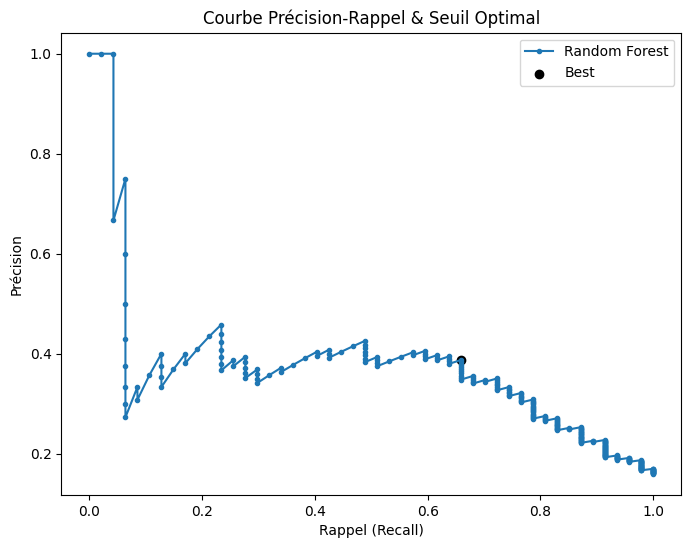


=== Matrice avec Seuil Optimal ===
[[198  49]
 [ 16  31]]


In [15]:
from sklearn.metrics import precision_recall_curve

# Récupérer les probabilités (et non les classes 0/1 directes)
y_scores = best_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcul du F1-score pour chaque seuil possible
fscore = (2 * precision * recall) / (precision + recall)
# Localiser l'index du meilleur F1
ix = np.argmax(fscore)

print(f"Meilleur Seuil (Threshold) = {thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}")

# Affichage Courbe
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel & Seuil Optimal')
plt.legend()
plt.show()

# --- APPLICATION DU SEUIL ---
# On ne prédit plus avec predict(), mais avec le seuil personnalisé
y_pred_optimal = (y_scores >= thresholds[ix]).astype(int)

print("\n=== Matrice avec Seuil Optimal ===")
print(confusion_matrix(y_test, y_pred_optimal))

Seuil optimal identifié : 0.372 (Max F1-Score : 0.488)


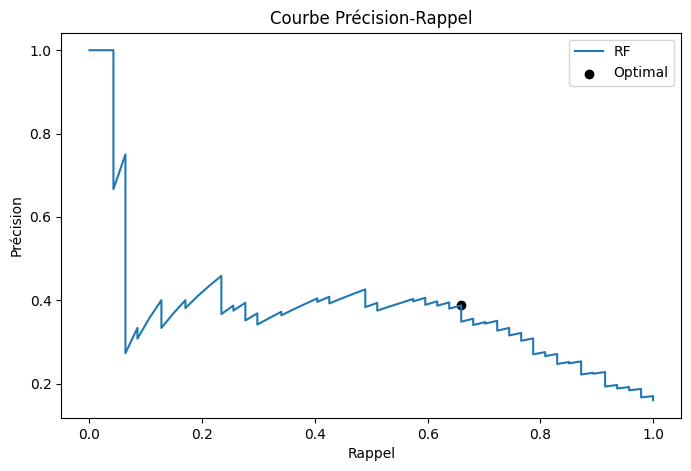

In [16]:
# --- Détermination du Seuil Optimal (Precision-Recall Curve) ---
from sklearn.metrics import precision_recall_curve

# Prédiction des probabilités
y_probs = best_rf.predict_proba(X_test)[:, 1]

# Calcul de la courbe et du F-Score
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
fscores = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscores)
best_thresh = thresholds[ix]

print(f"Seuil optimal identifié : {best_thresh:.3f} (Max F1-Score : {fscores[ix]:.3f})")

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='RF')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Optimal')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend()
plt.show()

Calcul des valeurs SHAP (Méthode moderne)...

=== Comparaison : Permutation Importance vs SHAP ===


,Permutation,SHAP
heure_supplementaires_Oui,0.021769,0.058969
note_evaluation_precedente,0.005442,NaN
ratio_stagnation,0.004082,NaN
poste_Cadre Commercial,0.004082,NaN
distance_domicile_travail,0.003401,NaN
taux_volatilite,NaN,0.050688
nombre_participation_pee,NaN,0.037742
age,NaN,0.036033
annes_sous_responsable_actuel,NaN,0.027408



=== Summary Plot (Global) ===


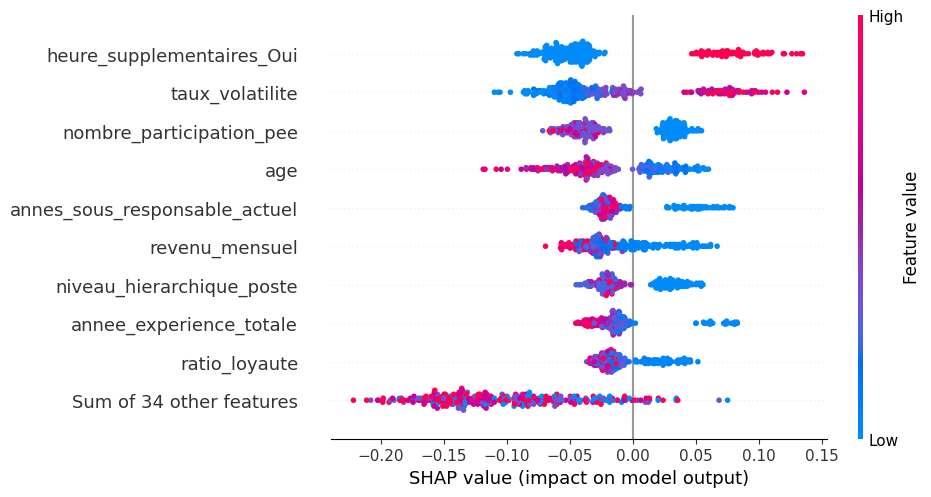


=== Scatter Plot pour la variable : heure_supplementaires_Oui ===


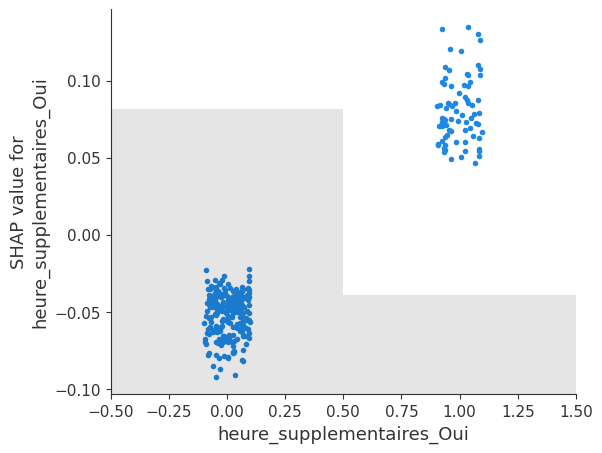


=== Analyse Locale : Comparaison Départ vs Reste ===
--- Employé Fidèle (Index 0) ---


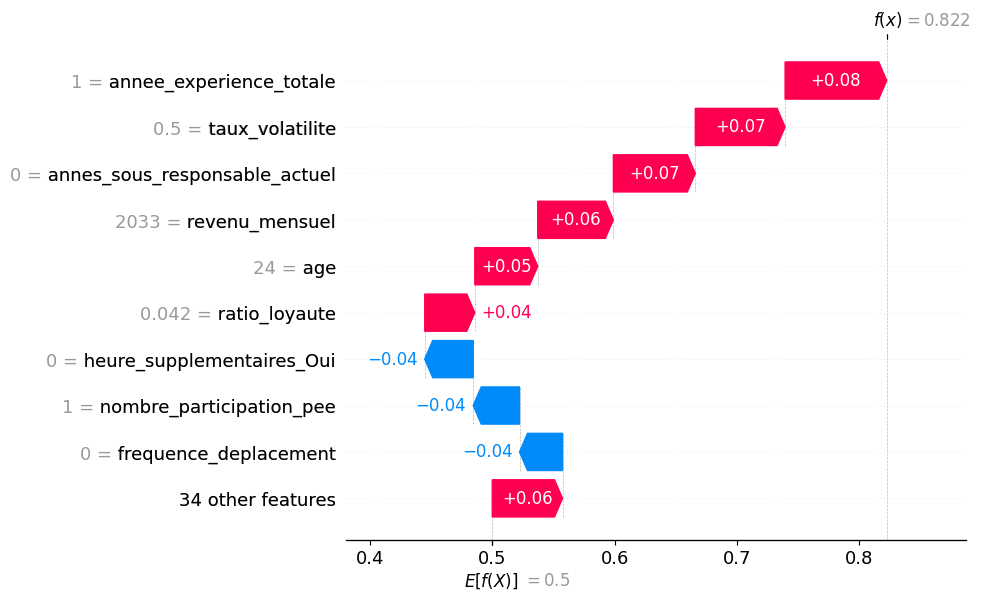

--- Employé Démissionnaire (Index 4) ---


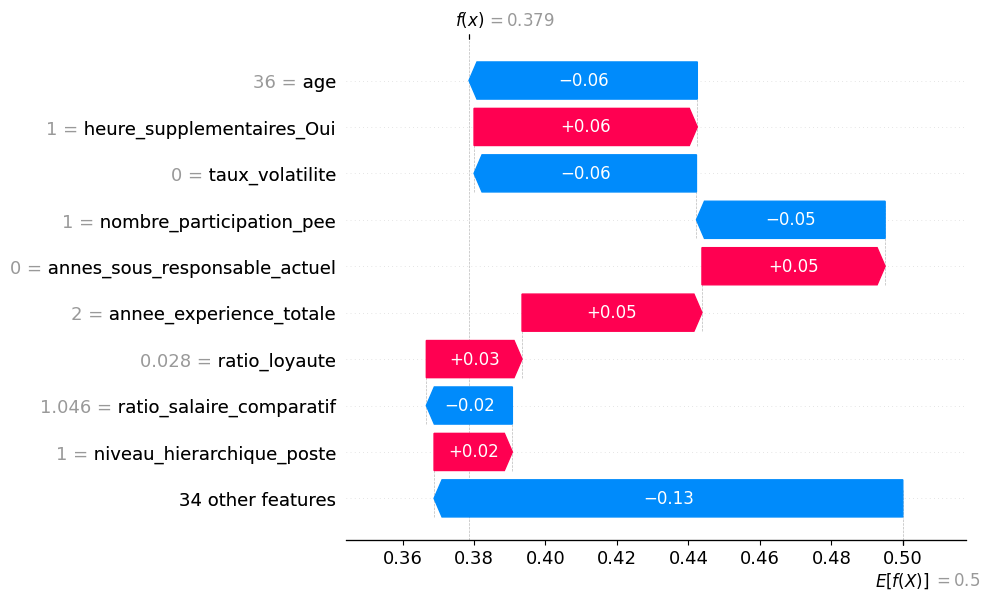

In [ ]:
# --- Initialisation JS pour les graphiques interactifs ---
shap.initjs()

print("Calcul des valeurs SHAP (Méthode moderne)...")
# 1. Création de l'explainer
explainer = shap.TreeExplainer(best_rf)

# 2. Calcul DIRECT de l'objet Explanation (C'est là que ça change tout)
shap_object = explainer(X_test)

# 3. Gestion Multiclasse : On isole la CLASSE 1 (Démission)

if len(shap_object.shape) == 3:
    # On sélectionne tout les samples, toutes les features, et l'index 1 (Classe 1)
    shap_class1 = shap_object[:, :, 1]
else:
    shap_class1 = shap_object


print("\n=== Comparaison : Permutation Importance vs SHAP ===")
# Calcul Permutation (sklearn)
perm_imp = permutation_importance(best_rf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame(perm_imp.importances_mean, index=X_test.columns, columns=['Permutation'])

# Calcul SHAP Importance (Moyenne absolue des valeurs)
shap_df = pd.DataFrame(np.abs(shap_class1.values).mean(axis=0), index=X_test.columns, columns=['SHAP'])

# Affichage comparatif (Top 5)
comparison = pd.concat([perm_df.sort_values('Permutation', ascending=False).head(5), 
                        shap_df.sort_values('SHAP', ascending=False).head(5)], axis=1)
try:
    display(comparison)
except:
    print(comparison)

# Beeswarm
print("\n=== Summary Plot (Global) ===")
# shap.plots.beeswarm est la nouvelle fonction dédiée à l'objet Explanation
plt.figure()
shap.plots.beeswarm(shap_class1, max_display=10, show=False)
plt.show()


# On prend la variable la plus importante (index 0 du df trié)
top_feature_name = shap_df.sort_values('SHAP', ascending=False).index[0]
print(f"\n=== Scatter Plot pour la variable : {top_feature_name} ===")
# L'objet shap_class1 contient déjà les info pour colorer automatiquement
shap.plots.scatter(shap_class1[:, top_feature_name])

# Waterfall
print("\n=== Analyse Locale : Comparaison Départ vs Reste ===")

# Récupération des indices pour l'exemple
y_arr = y_test.values.ravel() if hasattr(y_test, 'values') else y_test
idx_stay = np.where(y_arr == 0)[0][0]  # Premier qui reste
idx_leave = np.where(y_arr == 1)[0][0] # Premier qui part

print(f"--- Employé Fidèle (Index {idx_stay}) ---")
# Ici on passe un SEUL individu de l'objet shap_class1, c'est automatiquement un objet Explanation valide
shap.plots.waterfall(shap_class1[idx_stay])

print(f"--- Employé Démissionnaire (Index {idx_leave}) ---")
shap.plots.waterfall(shap_class1[idx_leave])